## Deep Learning with PyTorch : Neural Style Transfer

## Task 1 : Set Google Colab runtime

![](https://archive.org/download/deep-learning-with-py-torch/Deep%20Learning%20with%20PyTorch.png)

In [ ]:
!pip install torch torchvision

In [ ]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 19 (delta 2), reused 1 (delta 1), pack-reused 16
Receiving objects: 100% (19/19), 3.30 MiB | 7.20 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Task 2 : Loading VGG Pretrained Model

In [ ]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained = True)
print(vgg)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 91.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
vgg = vgg.features

print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
for parameters in vgg.parameters():

  parameters.requires_grad_(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
vgg.to(device);

## Task 3 : Preprocess image

Torchvision models page : https://pytorch.org/docs/stable/torchvision/models.html

In [33]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):

  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size

  else:
    size = max(image.size)

  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize(mean = [0.485, 0.456, 0.406],
                  std = [0.299, 0.244, 0.225])
  ])

  image = img_transforms(image)

  image = image.unsqueeze(0) #(3, 224, 224) -> (1, 3, 224, 224)

  return image

In [34]:
content_p = preprocess('/content/Project-NST/content11.jpg')
style_p = preprocess('/content/Project-NST/style11.jpg')

content_p = content_p.to(device)
style_p = style_p.to(device)

print("Content Shape", content_p.shape)
print("Syle Shape", style_p.shape)

Content Shape torch.Size([1, 3, 259, 345])
Syle Shape torch.Size([1, 3, 500, 577])


## Task 4 : Deprocess image

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):

  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0) #(1, 3, 224, 224) -> (3, 224, 224)
  image = image.transpose(1, 2, 0) #(3, 224, 224) ->(224, 224, 3)
  image = image * np.array([0.299, 0.244, 0.225]) + np.mean([0.485, 0.456, 0.406])
  image = image.clip(0, 1)

  return image

In [36]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print("Deprocess content : ", content_d.shape)
print("Style style : ", style_d.shape)

Deprocess content :  (259, 345, 3)
Style style :  (500, 577, 3)


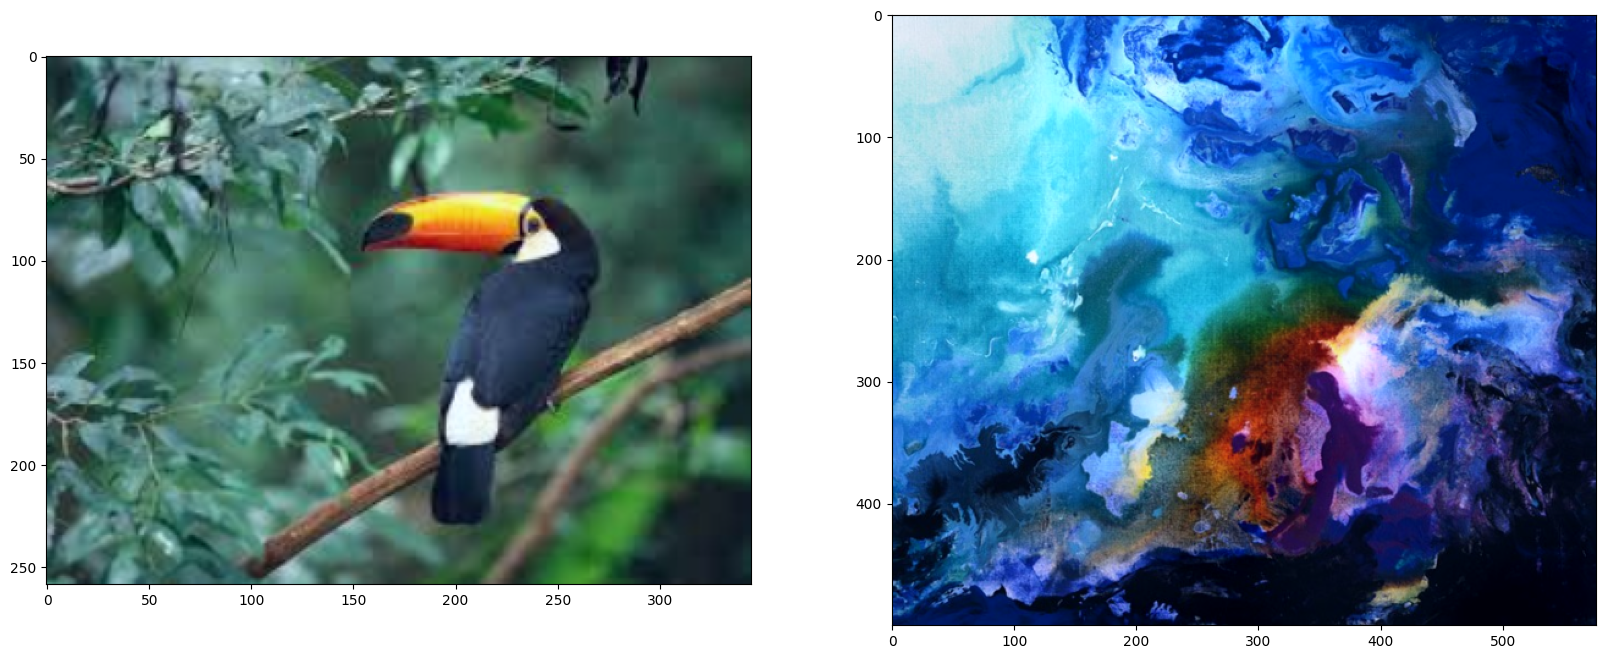

In [37]:
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize = (20, 10))

ax1.imshow(content_d)
ax2.imshow(style_d)

## Task 5 : Get content,style features and create gram matrix

In [38]:
def get_features(image, model):

  layers = {

      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2',    # Content feature, outers are style feature
      '28' : 'conv5_1'
  }

  x = image

  Features = {}

  for name, layer in model._modules.items():

    x = layer(x)

    if name in layers:

      Features[layers[name]] = x

  return Features


In [39]:
content_f = get_features(content_p, vgg)
style_f = get_features(style_p, vgg)

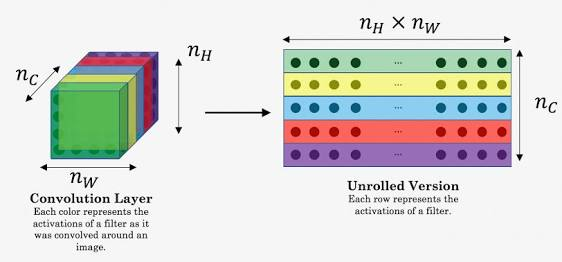

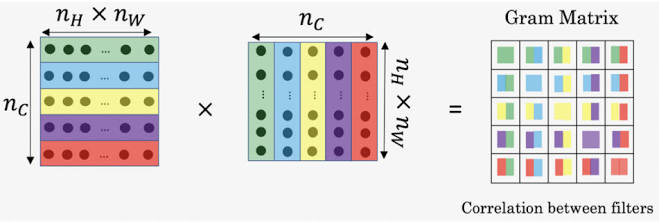

In [40]:
def gram_matrix(tensor):

  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h * w)
  gram = torch.mm(tensor, tensor.t())

  return gram

In [41]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}

## Task 6 : Creating Style and Content loss function

In [42]:
def content_loss(target_conv4_2, content_conv4_2):

  loss = torch.mean((target_conv4_2 - content_conv4_2)**2)

  return loss

In [43]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.75,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [45]:
def style_loss(style_weights, target_features, style_grams):

  loss = 0

  for layer in style_weights:
    target_f =target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b, c, h, w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss / (c * h * w)

    return loss

In [46]:
target = content_p.clone().requires_grad_(True).to(device)

target_f = get_features(target, vgg)

print("Content Loss : ", content_loss(target_f['conv4_2'], content_f['conv4_2']))
print("Style Loss : ", style_loss(style_weights, target_f, style_grams))


Content Loss :  tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss :  tensor(1499.3331, device='cuda:0', grad_fn=<AddBackward0>)


## Task 7 : Training loop

In [47]:
from torch import optim

optimizer = optim.Adam([target], lr = 0.003)

alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

In [48]:
def total_loss(c_loss, s_loss, alpha, beta):

  loss = alpha * c_loss + beta * s_loss

  return loss

In [50]:
results = []

for i in range(epochs):

  target_f = get_features(target, vgg)

  c_loss = content_loss(target_f['conv4_2'], content_f['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every ==0:
    print("Total Loss at Epoch {} : {}".format(i, t_loss))
    results.append(deprocess(target.detach()))

Total Loss at Epoch 0 : 149801328.0
Total Loss at Epoch 500 : 8393438.0
Total Loss at Epoch 1000 : 4983937.0
Total Loss at Epoch 1500 : 3367489.25
Total Loss at Epoch 2000 : 2578249.5
Total Loss at Epoch 2500 : 2155303.5


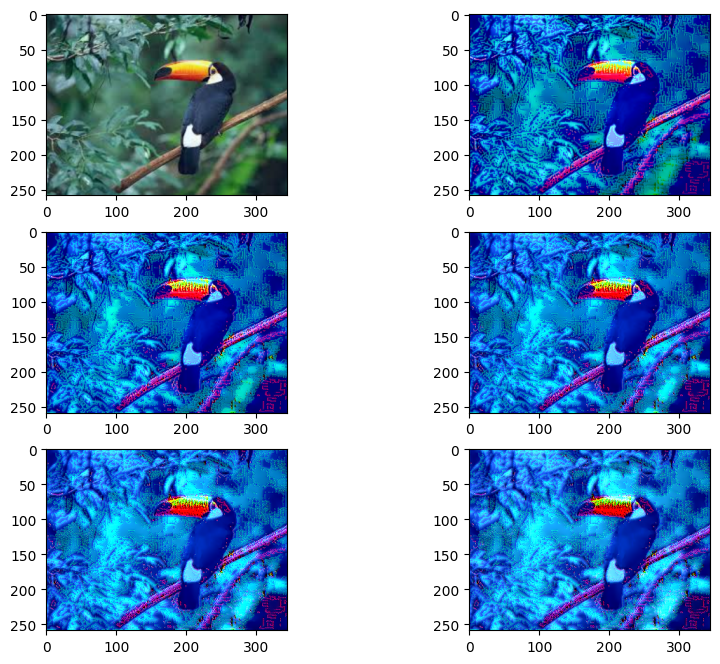

In [51]:
plt.figure(figsize = (10, 8))

for i in range(len(results)):

  plt.subplot(3, 2, i+1)
  plt.imshow(results[i])

plt.show()

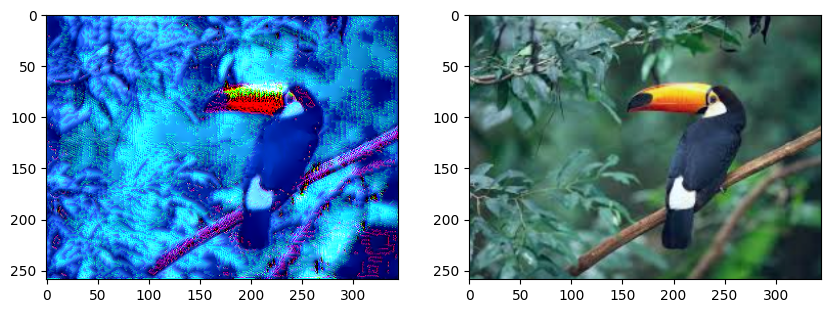

In [53]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_p)

content_copy = deprocess(content_p)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)